In [5]:
!pip install tensorboardx 
!pip install pyyaml docopt matplotlib scikit-image


  Using cached docopt-0.6.2.tar.gz (25 kB)
  Preparing metadata (setup.py) ... done
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=a487f48a1f77f374eabe1eccac013d9413308f00adf2a773ffc203f9c930940c
  Stored in directory: /home/raghib/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.3
    Uninstalling numpy-1.22.3:
      Successfully uninstalled numpy-1.22.3


In [33]:
del(infer)

In [2]:

import os
import os.path as osp
import pprint
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage.transform
import torch
import yaml
from docopt import docopt

import lcnn
from lcnn.config import C, M
from lcnn.models.line_vectorizer import LineVectorizer
from lcnn.models.multitask_learner import MultitaskHead, MultitaskLearner
from lcnn.postprocess import postprocess
from lcnn.utils import recursive_to

PLTOPTS = {"color": "#33FFFF", "s": 15, "edgecolors": "none", "zorder": 5}
cmap = plt.get_cmap("jet")
norm = mpl.colors.Normalize(vmin=0.9, vmax=1.0)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])


def c(x):
    return sm.to_rgba(x)


def load_model():
    config_file =  "config/wireframe.yaml"
    C.update(C.from_yaml(filename=config_file))
    M.update(C.model)
    pprint.pprint(C, indent=4)

    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)

    device_name = "cpu"
    if torch.cuda.is_available():
        device_name = "cuda"
        torch.backends.cudnn.deterministic = True
        torch.cuda.manual_seed(0)
        print("Let's use", torch.cuda.device_count(), "GPU(s)!")
    else:
        print("CUDA is not available")
    device = torch.device(device_name)
    checkpoint = torch.load("190418-201834-f8934c6-lr4d10-312k.pth", map_location=device)

    # Load model
    model = lcnn.models.hg(
        depth=M.depth,
        head=lambda c_in, c_out: MultitaskHead(c_in, c_out),
        num_stacks=M.num_stacks,
        num_blocks=M.num_blocks,
        num_classes=sum(sum(M.head_size, [])),
    )
    model = MultitaskLearner(model)
    model = LineVectorizer(model)
    model.load_state_dict(checkpoint["model_state_dict"])
    model = model.to(device)
    model.eval()
    return model,device
def infer(model,im,device):
    if isinstance(im,str):
        im = skimage.io.imread(im)
    
    if im.ndim == 2:
        im = np.repeat(im[:, :, None], 3, 2)
    im = im[:, :, :3]
    im_resized = skimage.transform.resize(im, (512, 512)) * 255
    image = (im_resized - M.image.mean) / M.image.stddev
    image = torch.from_numpy(np.rollaxis(image, 2)[None].copy()).float()
    with torch.no_grad():
        input_dict = {
            "image": image.to(device),
            "meta": [
                {
                    "junc": torch.zeros(1, 2).to(device),
                    "jtyp": torch.zeros(1, dtype=torch.uint8).to(device),
                    "Lpos": torch.zeros(2, 2, dtype=torch.uint8).to(device),
                    "Lneg": torch.zeros(2, 2, dtype=torch.uint8).to(device),
                }
            ],
            "target": {
                "jmap": torch.zeros([1, 1, 128, 128]).to(device),
                "joff": torch.zeros([1, 1, 2, 128, 128]).to(device),
            },
            "mode": "testing",
        }
        H = model(input_dict)["preds"]

    lines = H["lines"][0].cpu().numpy() / 128 * im.shape[:2]
    scores = H["score"][0].cpu().numpy()
    for i in range(1, len(lines)):
        if (lines[i] == lines[0]).all():
            lines = lines[:i]
            scores = scores[:i]
            break

    # postprocess lines to remove overlapped lines
    diag = (im.shape[0] ** 2 + im.shape[1] ** 2) ** 0.5
    nlines, nscores = postprocess(lines, scores, diag * 0.01, 0, False)
    # keep_idx=nscores>0.93
    # nlines,nscores=nlines[keep_idx,:],nscores[keep_idx]
    return nlines,nscores,im
            

In [32]:
from doctr.io import DocumentFile
from doctr.models import ocr_predictor
import cv2
model = ocr_predictor(pretrained=True)
# PDF
doc = cv2.cvtColor(cv2.imread('test.png'),cv2.COLOR_BGR2GB)
# Analyze
result = model(doc)

KeyboardInterrupt: 

In [24]:
class Line:
    def __init__(self, point1, point2):
        """
        Initialize the li4467ne using two points (x1, y1) and (x2, y2).

        Args:
            point1 (tuple): The first point (x1, y1).
            point2 (tuple): The second point (x2, y2).
        """
        y1, x1 = point1
        y2, x2 = point2


        # Calculate the slope (m) and intercept (b)
        self.m = (y2 - y1) / ((x2 - x1)+1e-5)
        self.b = y1 - self.m * x1
        self.is_vertical=abs(self.m)>1
        self.is_horizontal=abs(self.m)<1
        if self.is_horizontal:
            self.point1,self.point2=sorted([point1,point2],key=lambda x:x[1])
        else:
            self.point1,self.point2=sorted([point1,point2],key=lambda x:x[0])

    def y(self, x):
        """
        Calculate y for a given x using the line equation y = mx + b.

        Args:
            x (float): The x-coordinate.

        Returns:
            float: The corresponding y-coordiis_verticalnate.
        """
        return self.m * x + self.b

    def x(self, y):
        """
        Calculate x for a given y using the inverse of the line equation x = (y - b) / m.

        Args:,nscores
            y (float): The y-coordinate.

        Returns:
            float: The corresponding x-coordinate.
        """
        if self.m == 0:
            raise ValueError("The slope (m) is zero; the line is horizontal.")
        
        return (y - self.b) / self.m
    def stretch_limits(self,low_limit,high_limit):
        if self.is_horizontal:
            self.point1=low_limit
            self.point2=high_limit
        else:
            if isinstance(low_limit,(tuple,list)):
                self.point1=low_limit
            else:
                self.point1=(low_limit,self.x(low_limit))
            if isinstance(high_limit,(tuple,list)):
                self.point2=high_limit
            else:
                self.point2=(high_limit,self.x(high_limit))



    def __repr__(self):
        return str(self.__dict__)

class LineManager():
    def __init__(self,nlines,im):
        lines=[Line(a,b) for a,b in nlines]
        self.v_l=[]
        self.h_l=[]
        for a,b in nlines:
            y1,x1=a#line.point1
            y2,x2=b#line.point2
            if abs(y2-y1)/abs(x2-x1+1e-05)>1:
                min_x=min(x1,x2)
                x1=x2=min_x
                self.v_l.append(Line((y1,x1),(y2,x2)))
            elif abs(y2-y1)/abs(x2-x1+1e-05)<1:
                max_y=max(y1,y2)
                y1=y2=max_y
                self.h_l.append(Line((y1,x1),(y2,x2)))
        
        spaces=lambda x:[np.sqrt((np.array(line.point2)-np.array(line.point1))@(np.array(line.point2)-np.array(line.point1)).T) for line in x]
        
        # lines=[line for line,space in zip(lines,spaces) if space>0.01]
        # self.v_l=[]
        # self.h_l=[]
        # for line in lines:
        #     if line.is_vertical:
        #         self.v_l.append(line)
        #     else:
        #         self.h_l.append(line)
        self.v_l=sorted(self.v_l,key=lambda x:x.point1[1])
        self.h_l=sorted(self.h_l,key=lambda x:x.point1[0])
        
        self.v_spaces=spaces(self.v_l) 
        self.h_spaces=spaces(self.h_l)
        # self.v_spaces=[i/max(self.v_spaces)self.h_spaces for i in self.v_spaces]
        # self.h_spaces=[i/max(self.h_spaces) for i in self.h_spaces]
        self.im_height,self.im_width=im.shape[:2]
    
    def save_words(self,words_bbox):
        self.words=words_bbox


    def calc_euc(self,a,b):
        a_min_b = np.array(a) - np.array(b)
        return np.sqrt(np.einsum('ij,ij->j', a_min_b, a_min_b))[0]
    def extend_row_lines(self):
        for idx,(line) in enumerate(self.h_l):
            if self.h_spaces[idx]>0.2:
                low_cols=[l.point1[1] for l in self.v_l if l.point1[1]<line.point1[1]]
                high_cols=[l.point1[1] for l in self.v_l if l.point1[1]>line.point2[1]]
                if low_cols: 
                    low_lim= (line.y(max(low_cols)-1),max(low_cols)-1)     
                else:
                    low_lim=(line.point1[0],line.point1[1]-1)
                if high_cols:
                    high_lim=(line.y(min(high_cols)+1),min(high_cols)+1)
                else:
                    high_lim=(line.point2[0],line.point2[1]+1)
                
                words=self.filter_boxes_in_extended_range(line,self.words,low_p=low_lim,high_p=high_lim)
                self.h_l[idx]=self.line_intersects_box(line,words,low_lim,high_lim)
    
    def stretch_column_lines(self):
        for idx, (line) in enumerate(self.v_l):
            #     self.v_l[idx].stretch_limits(lowest_limit, highest_limit)
            # else:
            if self.v_spaces[idx]>0.2:
                low_rows = [l.point1[0] for l in self.h_l if l.point1[0] < line.point1[0]]
                high_rows = [l.point1[0] for l in self.h_l if l.point1[0]> line.point2[0]]                
                if low_rows:
                    low_lim = (max(low_rows) - 1,line.x(max(low_rows) - 1))
                else:
                    low_lim=(line.point1[0]-1,line.point1[1])
                if high_rows:
                    high_lim=(min(high_rows)+1,line.x(min(high_rows)+1))
                else:
                    high_lim=(line.point2[0]+1,line.point2[1])
                
                words=self.filter_boxes_in_extended_range(line,self.words,low_p=low_lim,high_p=high_lim)
                self.v_l[idx]=self.line_intersects_box(line,words,low_lim,high_lim)

    def get_intersections(self):
        self.extend_row_lines()
        self.stretch_column_lines()
        self.intersections=[[],]
        for h_idx,h_line in enumerate(self.h_l):
            for v_idx,v_line in enumerate(self.v_l):
                h_line_y=(h_line.point1[0]+h_line.point2[0])/2
                if (h_line_y>=v_line.point1[0] and h_line_y<=v_line.point2[0]) and (h_line.point1[1]<=min(v_line.point1[1],v_line.point2[1]) or h_line.point2[1]>=max(v_line.point1[1],v_line.point2[1])):
                    self.intersections[-1].append((h_line_y,v_line.x(h_line_y)))
            self.intersections.append([])

    def get_boxes_close_to_line(self,line,w_boxes=None,low_lim=None,high_lim=None):
        p1_boxes=[]
        p2_boxes=[]
        for box in w_boxes:
            x1_box, y1_box, x2_box, y2_box=box
            if line.is_vertical:
                y_top = low_lim[0]  # lower y-coordinate of the line
                y_bottom = high_lim[0]  # higher y-coordinate of the line
                if (low_lim[0]<=box[-1]<=line.point1[0]) and (x1_box <= line.point1[1] <= x2_box):
                    p1_boxes.append(box)
                elif (line.point2[0]<=box[1]<=high_lim[0]) and (x1_box<=line.point2[1]<=x2_box):
                    p2_boxes.append(box)
        
            elif line.is_horizontal:
                # Check if the y-coordinate of the line falls within the top-bottom range of the box
                x_left = low_lim[1]  # lower x-coordinate of the line
                x_right = high_lim[1]  # higher x-coordinate of the line
                
                if low_lim[1]<=box[-2]<=line.point1[1] and y1_box <=line.point1[0] <= y2_box:
                    p1_boxes.append(box)
                elif line.point2[1]<=box[0]<=high_lim[1] and y1_box <=line.point2[0] <= y2_box:
                    p2_boxes.append(box)            
            return p1_boxes,p2_boxes
        

    def line_intersects_box(self, line, w_boxes=None,low_lim=None,high_lim=None):
        """
        Check if a given line intersects a word box.

        Args:
            line (Line): The Line object.
            word_box (tuple): The word box as a tuple (x1_box, y1_box, x2_box, y2_box).

        Returns:
            bool: True if the line intersects the word box, False otherwise.
        """
            
            # Case 1: Check if the line is vertical
        if not w_boxes:
            w_boxes=self.words
        if line.is_vertical:
            y_top = low_lim[0]  # lower y-coordinate of the line
            y_bottom = high_lim[0]  # higher y-coordinate of the line
                    
            top_boxes=[]
            bot_boxes=[]
            for x1_box, y1_box, x2_box, y2_box in w_boxes:
                if (low_lim[0]<=box[-1]<=line.point1[0]) and (x1_box <= line.point1[1] <= x2_box):
                    top_boxes.append(box)
                elif (line.point2[0]<=box[1]<=high_lim[0]) and (x1_box<=line.point2[1]<=x2_box):
                    bot_boxes.append(box)            
            
            for x1_box, y1_box, x2_box, y2_box in top_boxes:
                # x1_box, y1_box, x2_box, y2_box = word_box

            # Check if the x-coordinate of the line falls within the left-right range of the box
                # if x1_box <= line.point1[1] <= x2_box:
                    # ####################
                if not (y1_box <= y_top <= y2_box):
                    point1=low_lim
                else:
                    point1=line.point1
                    break

            for word_box in bot_boxes:
                x1_box, y1_box, x2_box, y2_box = word_box
                if x1_box<=line.point2[1]<=x2_box:
                    if not (y1_box <= y_bottom <= y2_box):
                        point2=high_lim
                    else:
                        point2=line.point2
                        break
            return Line(point1,point2)
        # Case 2: Check if the line is horizontal
        elif line.is_horizontal:
            # Check if the y-coordinate of the line falls within the top-bottom range of the box
            x_left = low_lim[1]  # lower x-coordinate of the line
            x_right = high_lim[1]  # higher x-coordinate of the line
            left_boxes=[]
            right_boxes=[]
            for box in w_boxes:
                if low_lim[1]<=box[-2]<=line.point1[1]:
                    left_boxes.append(box)
                elif line.point2[1]<=box[0]<=high_lim[1]:
                    right_boxes.append(box)            
            for word_box in left_boxes:
                x1_box, y1_box, x2_box, y2_box = word_box

                if y1_box <=line.point1[0] <= y2_box:
                # Now check if the line intersects the left or right side of the box
                    if not (x1_box <= x_left <= x2_box):
                        line.point1=low_lim
                    else:
                        point1=line.point1
                        break
            for word_box in right_boxes:
                x1_box, y1_box, x2_box, y2_box = word_box

                if y1_box <=line.point1[0] <= y2_box:
                # Now check if the line intersects the left or right side of the box
                    if not (x1_box <= x_right <= x2_box):
                        line.point2=high_lim
                    else:
                        point2=line.point2
                        break    
            return Line(point1,point2)
    

    def filter_boxes_in_extended_range(self,line, word_boxes, low_p, high_p):
        """
        Filter word boxes that exist within the space to be extended, not the current span of the line.

        Args:
            line (Line): The Line object.
            word_boxes (list): A list of word boxes, where each word box is a tuple (x1, y1, x2, y2).
            extend_x (int): Amount to extend the line in the x direction.
            extend_y (int): Amount to extend the line in the y direction.

        Returns:
            list: A filtered list of word boxes that exist only in the extended space.
        """
        filtered_boxes = []
        y_min,x_min=line.point1
        y_max,x_max=line.point2
        # For vertical-like lines, consider only boxes that exist within the extended y-range
        if line.is_vertical:
            # We want to check only boxes in the extended space (above y_max or below y_min)
            extended_y_min = low_p[0]  # Space below the current span
            extended_y_max = high_p[0]  # Space above the current span
            
            # Filter word boxes that are within the extended y-range, ignoring the current span
            filtered_boxes = [
                box for box in word_boxes 
                if (extended_y_min <= box[3] <= y_min) or (y_max <= box[1] <= extended_y_max)
            ]

        # For horizontal-like lines, consider only boxes that exist within the extended x-range
        elif line.is_horizontal:
            # Determine the current horizontal span (x-axis) of the line
            # We want to check only boxes in the extended space (left of x_min or right of x_max)
            extended_x_min = low_p[1]  # Space left of the current span
            extended_x_max = high_p[1]  # Space right of the current span

            # Filter word boxes that are within the extended x-range, ignoring the current span
            filtered_boxes = [
                box for box in word_boxes
                if (extended_x_min <= box[2] <= x_min) or (x_max <= box[0] <= extended_x_max)
            ]

        return filtered_boxes


    def check_line_intersects_extended_word_boxes(self,line, word_boxes, low_p, high_p):
        """
        Check if a line intersects any word box in a filtered list of word boxes
        that exist only in the extended space (not in the current span of the line).

        Args:
            line (Line): The Line object.
            word_boxes (list): A list of word boxes, where each word box is a tuple (x1, y1, x2, y2).
            extend_x (int): Amount to extend the line in the x direction.
            extend_y (int): Amount to extend the line in the y direction.

        Returns:
            bool: True if the line intersects any word box, False otherwise.
        """
        # Filter the word boxes that exist in the extended space (beyond the current line span)
        filtered_boxes = self.filter_boxes_in_extended_range(line, word_boxes, low_p, high_p)

        # Check for intersection with the filtered word boxes
        for word_box in filtered_boxes:
            if self.line_intersects_box(line, word_box):
                return True

        return False

    def __repr__(self):
        return str(self.__dict__)



In [25]:
model,device=load_model()

<Box: {'io': {'logdir': 'logs/', 'datadir': 'data/wireframe/', 'resume_from': None, 'num_workers': 4, 'tensorboard_port': 0, 'validation_interval': 24000}, 'model': {'image': {'mean': [109.73, 103.832, 98.681], 'stddev': [22.275, 22.124, 23.229]}, 'batch_size': 6, 'batch_size_eval': 2, 'head_size': [[2], [1], [2]], 'loss_weight': {'jmap': 8.0, 'lmap': 0.5, 'joff': 0.25, 'lpos': 1, 'lneg': 1}, 'backbone': 'stacked_hourglass', 'depth': 4, 'num_stacks': 2, 'num_blocks': 1, 'n_stc_posl': 300, 'n_stc_negl': 40, 'n_dyn_junc': 300, 'n_dyn_posl': 300, 'n_dyn_negl': 80, 'n_dyn_othr': 600, 'n_pts0': 32, 'n_pts1': 8, 'dim_loi': 128, 'dim_fc': 1024, 'n_out_junc': 250, 'n_out_line': 2500, 'use_cood': 0, 'use_slop': 0, 'use_conv': 0, 'eval_junc_thres': 0.008}, 'optim': {'name': 'Adam', 'lr': 0.0004, 'amsgrad': True, 'weight_decay': 0.0001, 'max_epoch': 24, 'lr_decay_epoch': 10}}>
CUDA is not available


/tmp/ipykernel_44500/1628551544.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("190418-201834-f8934c6-lr4d10-312k.pth", map_location=device)


In [26]:
nlines,nscores,im=infer(model,'test.png',device)


In [27]:
line_m=LineManager(nlines,im)

In [28]:
line_m.v_l

[{'m': -48218447.61334359, 'b': 326203432.56920666, 'is_vertical': True, 'is_horizontal': False, 'point1': (7.713960234075785, 6.765106692910194), 'point2': (489.89843636751175, 6.765106692910194)},
 {'m': -38864167.85381734, 'b': 1812203272.6976705, 'is_vertical': True, 'is_horizontal': False, 'point1': (8.890705738216639, 46.62914389371872), 'point2': (397.5323842763901, 46.62914389371872)},
 {'m': -38876698.34494591, 'b': 5010704126.97145, 'is_vertical': True, 'is_horizontal': False, 'point1': (8.830024242401123, 128.88706970214844), 'point2': (397.5970076918602, 128.88706970214844)},
 {'m': -48069687.503762536, 'b': 10216733405.499458, 'is_vertical': True, 'is_horizontal': False, 'point1': (8.851924119517207, 212.54003190994263), 'point2': (489.54879915714264, 212.54003190994263)},
 {'m': -48057840.00698476, 'b': 20804538300.52156, 'is_vertical': True, 'is_horizontal': False, 'point1': (8.94406527839601, 432.9062190055847), 'point2': (489.5224653482437, 432.9062190055847)},
 {'m': 

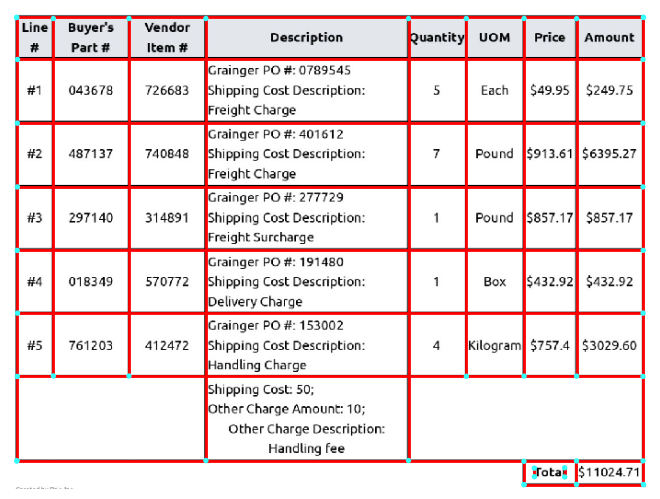

In [29]:
imname='test.png'
for i, t in enumerate([0.99]):
    plt.gca().set_axis_off()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    for line in line_m.h_l+line_m.v_l:
        a,b=line.point1,line.point2
        plt.plot([a[1], b[1]], [a[0], b[0]], c='red', linewidth=2)
        plt.scatter(a[1], a[0], **PLTOPTS)
        plt.scatter(b[1], b[0], **PLTOPTS)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.imshow(im)
    plt.show()
    plt.close()

In [31]:
[space/max(line_m.v_spaces) for space in line_m.v_spaces]

[0.9491156251150464,
 0.7649891440500095,
 0.7652357900021117,
 0.9461874813985711,
 0.9459542792764196,
 0.7657864789228491,
 0.049934242995690575,
 0.7654793758496984,
 0.01824730007714004,
 0.019532284189553027,
 0.05014506547707733,
 0.7653358718473003,
 1.0]

In [77]:
line_m.v_spaces

[1.0,
 0.21986341770954065,
 0.283943193607609,
 0.2206126751934826,
 0.019386407357067415,
 0.01833714630057779,
 0.28279163084760955,
 0.2188265148951184,
 0.2179472619557433,
 0.06373586706321872,
 0.0618480250042318,
 0.1237553504640081,
 0.28295152648974875,
 0.21843556453263682,
 0.21853538641883072,
 0.022459598173283992,
 0.21842360412254938,
 0.21813677334951256,
 0.28275714777801,
 0.018634935896256533,
 0.01911808269318817,
 0.21848793518316123,
 0.28303238321425983,
 0.21827274478458525,
 0.12444429444442616,
 0.06363154007893823,
 0.06173182162870278,
 0.9996086483720046]

In [79]:
lines=sorted([Line(a,b) for a,b in nlines],key=lambda line: line.point2[0]-line.point1[0] if line.is_vertical else line.point2[1]-line.point1[1])
spaces=sorted([np.sqrt((np.array(line.point2)-np.array(line.point1))@(np.array(line.point2)-np.array(line.point1)).T) if line.is_vertical else line.point2[1]-line.point1[1] for line in lines])


In [80]:
line_m=LineManager(nlines,im)

In [81]:
spaces

[12.097955485857398,
 12.294422548595474,
 12.61317925951452,
 12.790206796196522,
 14.817748327724924,
 30.761755406856537,
 40.727647469410385,
 40.80431279352422,
 41.98098912191639,
 42.049818981868995,
 81.64774913766578,
 82.10228080092052,
 143.79098198731188,
 143.91601236926456,
 144.00571969568784,
 144.10524933489123,
 144.1131402305878,
 144.1476918335703,
 144.1789978463745,
 144.37107022716162,
 145.0551681716518,
 145.54949174521076,
 186.54938620512507,
 186.5721364539475,
 186.67762780626995,
 186.73097313262733,
 187.33188144268684,
 659.4930712256761,
 659.7512659576806,
 839.4256289042532,
 842.7429826930165,
 842.8368425145745,
 842.8814991936088,
 843.1987861990929,
 843.3477718904614,
 843.3845955058932,
 843.8251505568624,
 843.9273603968322,
 843.9328757226467,
 844.0414396561682,
 844.1557551398873,
 891.1576732732356,
 892.0085577806458,
 908.5315247438848]

AttributeError: 'LineManager' object has no attribute 'intersections'

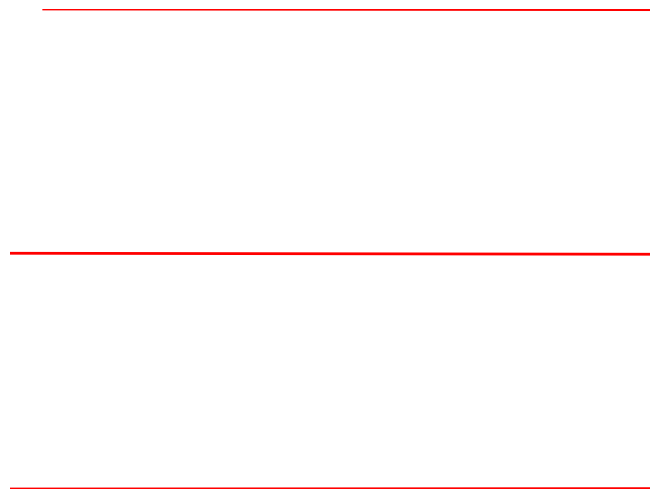

In [72]:
imname='test.png'
plt.gca().set_axis_off()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
for line in line_m.h_l[:3]:
    a,b=line.point1,line.point2
    plt.plot([a[1], b[1]], [a[0], b[0]], c='red', linewidth=2)
for line in line_m.intersections:
    for a in line:
        plt.scatter(a[1], a[0], **PLTOPTS)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.imshow(im)
plt.show()
plt.close()

In [61]:
1234567890-=-[-=============---------------======================]
1231342345

SyntaxError: invalid syntax (3369081993.py, line 1)